In [14]:
import pandas as pd
import numpy as np
import json
import scipy.signal
import matplotlib.pyplot as plt

def vel_filter(ang_vel_all):
    b, a = scipy.signal.butter(2, 0.1, 'lowpass')
    return scipy.signal.filtfilt(b, a, ang_vel_all)

# Load data
data = pd.read_csv('GazeDataColor/updated_gaze_data_color_jenna.csv', sep=',')

# Load JSON file for trial details
with open("trial_ids_segments/trials_color.json", "r") as f:
    trial_details = json.load(f)

# Process segment JSON data
def process_segments(trial_details):
    trial_data = []
    for trial in trial_details:
        trial_id = trial['trial_id']
        initial_ball = trial['initial_ball_placement']
        initial_crosshair = trial['initial_crosshair_placement']
        for segment in trial['segments']:
            trial_data.append({
                'trial_id': trial_id,
                'initial_ball_x': initial_ball['x'],
                'initial_ball_y': initial_ball['y'],
                'initial_crosshair_x': initial_crosshair['x'],
                'initial_crosshair_y': initial_crosshair['y'],
                'object_motion_x': segment['object_motion'][0],
                'object_motion_y': segment['object_motion'][1],
                'object_speed': segment['object_speed'],
                'camera_motion_x': segment['camera_motion'][0],
                'camera_motion_y': segment['camera_motion'][1],
                'camera_speed': segment['camera_speed'],
                'duration_start': segment['duration'][0],
                'duration_end': segment['duration'][1],
                'contrast_intensity': segment['contrast_intensity'],
                'contrast_direction_x': segment['contrast_direction'][0],
                'contrast_direction_y': segment['contrast_direction'][1],
                'contrast_direction_z': segment['contrast_direction'][2]
            })
    return pd.DataFrame(trial_data)

segment_df = process_segments(trial_details)

# Map TrialID to segments in CSV data
def map_camera_motion_type_and_object_speed(data_df, segment_df):
    data_df = data_df.merge(
        segment_df[['trial_id', 'object_motion_x', 'object_motion_y', 'object_speed', 'camera_motion_x', 'camera_motion_y', 'camera_speed', 'contrast_intensity']],
        left_on='TrialID', right_on='trial_id', how='left'
    )
    return data_df

data = map_camera_motion_type_and_object_speed(data, segment_df)

# Screen parameters
screen_width = 2560
screen_height = 1440
screen_diagonal_size = 27.5  # inches
distance_to_screen = 0.5842  # meters

# Process data
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
data['MappedPogX'] = data['BestPogX'] * screen_width
data['MappedPogY'] = screen_height - data['BestPogY'] * screen_height
data[['BallX', 'BallY']] = data['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
data = data[(data['BallX'] >= 0) & (data['BallY'] >= 0)]

# Apply filter to each trial
def apply_filter_per_trial(df, column_name, new_column_name):
    df[new_column_name] = df.groupby('TrialNumber')[column_name].transform(lambda x: vel_filter(x.fillna(0)))
    return df

data = apply_filter_per_trial(data, 'MappedPogX', 'FilteredPogX')
data = apply_filter_per_trial(data, 'MappedPogY', 'FilteredPogY')

# Compute angular error
def compute_position_dependent_angular_error(df, screen_width, screen_height, screen_diagonal_size, distance_to_screen):
    diagonal_resolution = np.sqrt(screen_width**2 + screen_height**2)
    pixel_size = diagonal_resolution / screen_diagonal_size  # Pixels per inch
    distance_to_screen_pixels = distance_to_screen * pixel_size * 39.37  # Convert meters to inches

    screen_center_x = screen_width / 2
    screen_center_y = screen_height / 2

    df['PixelDistance'] = np.sqrt((df['FilteredPogX'] - df['BallX'])**2 + (df['FilteredPogY'] - df['BallY'])**2)
    df['TargetToCenterDistance'] = np.sqrt((df['BallX'] - screen_center_x)**2 + (df['BallY'] - screen_center_y)**2)
    df['DistanceToScreenAdjusted'] = np.sqrt(distance_to_screen_pixels**2 + df['TargetToCenterDistance']**2)
    df['AngularError'] = np.degrees(np.arctan(df['PixelDistance'] / df['DistanceToScreenAdjusted']))
    
    return df

data = compute_position_dependent_angular_error(data, screen_width, screen_height, screen_diagonal_size, distance_to_screen)

# Discard trials with high angular error
def discard_trials_with_high_angular_error(df, angular_error_threshold):
    trials_to_discard = df[df['AngularError'] > angular_error_threshold]['TrialNumber'].unique()
    return df[~df['TrialNumber'].isin(trials_to_discard)]

angular_error_threshold = 30.0
data = discard_trials_with_high_angular_error(data, angular_error_threshold)


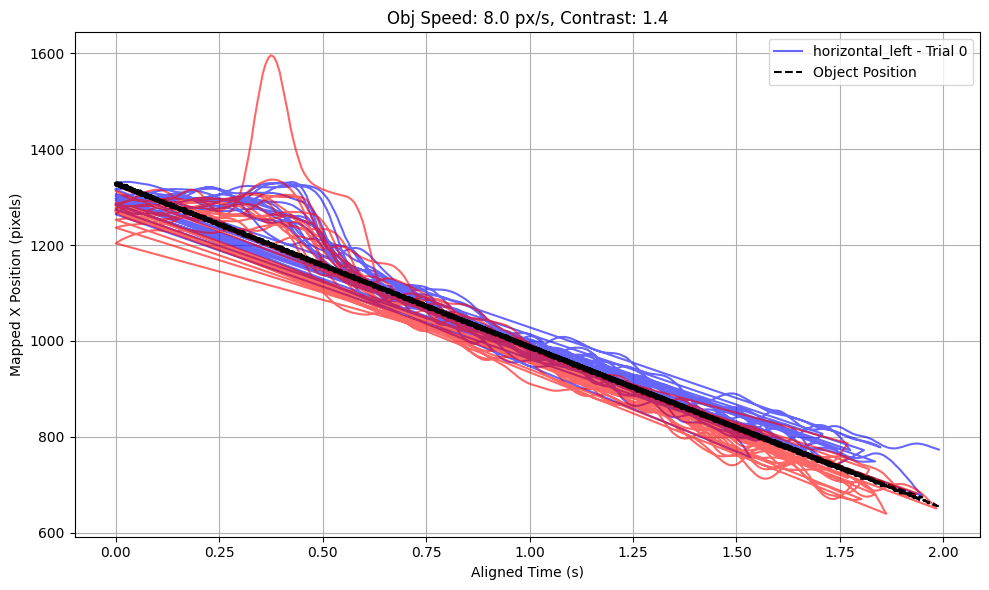

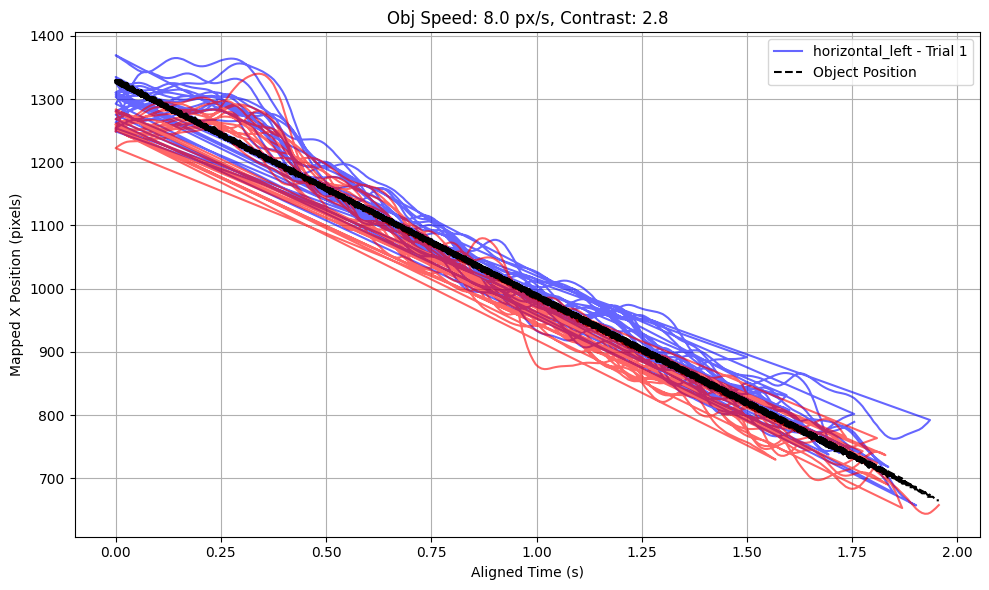

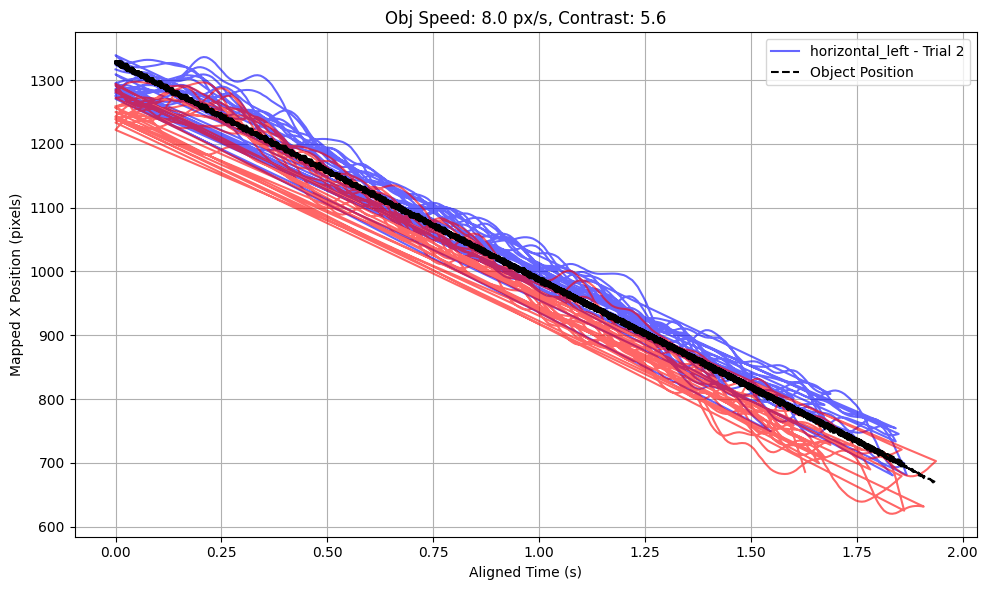

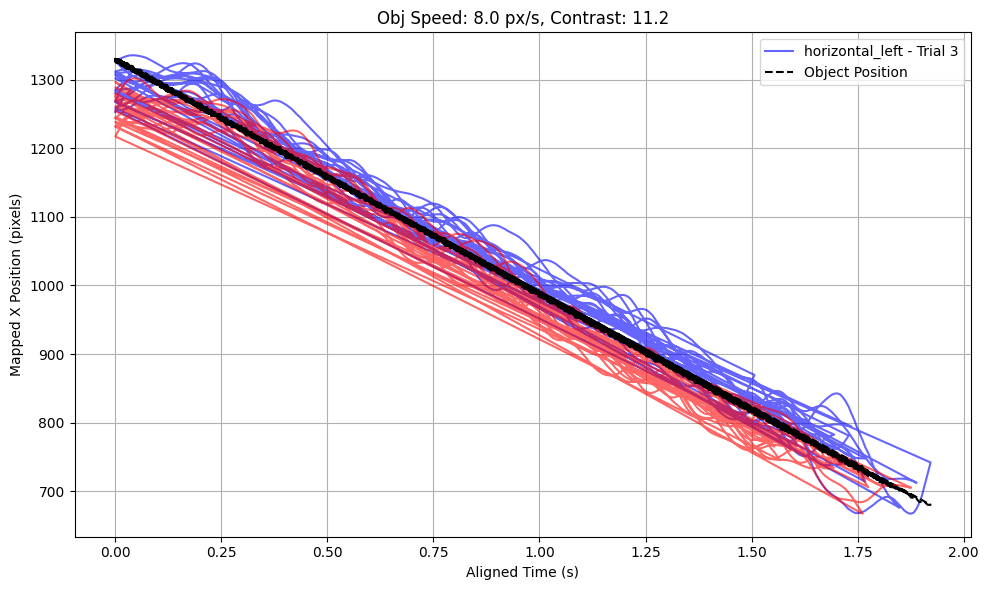

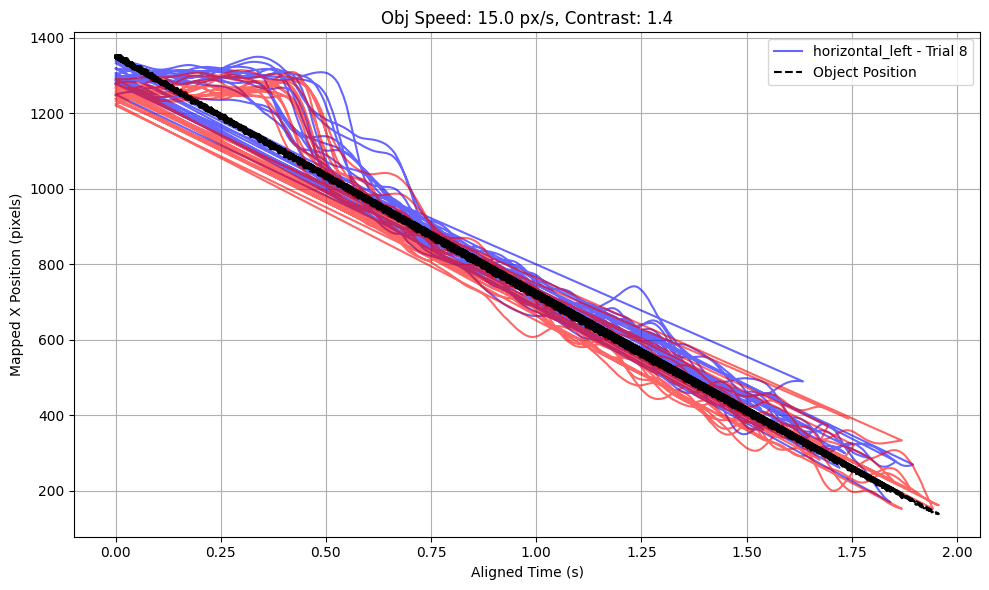

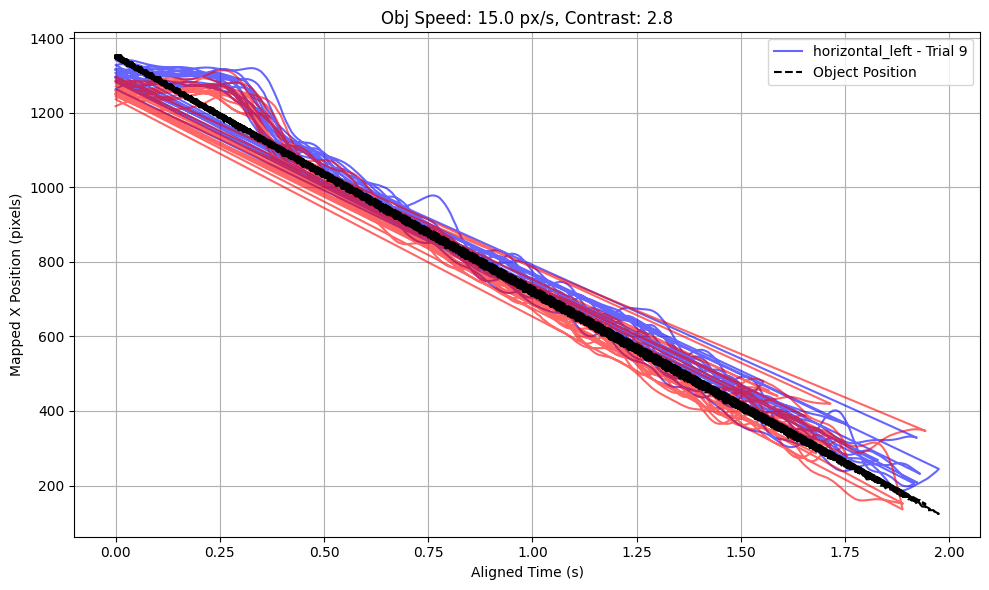

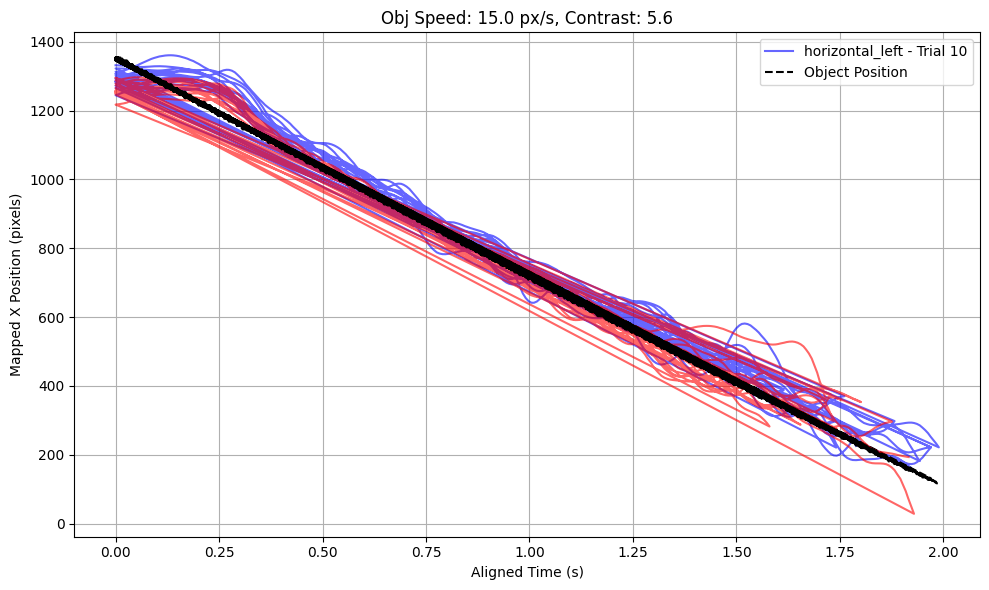

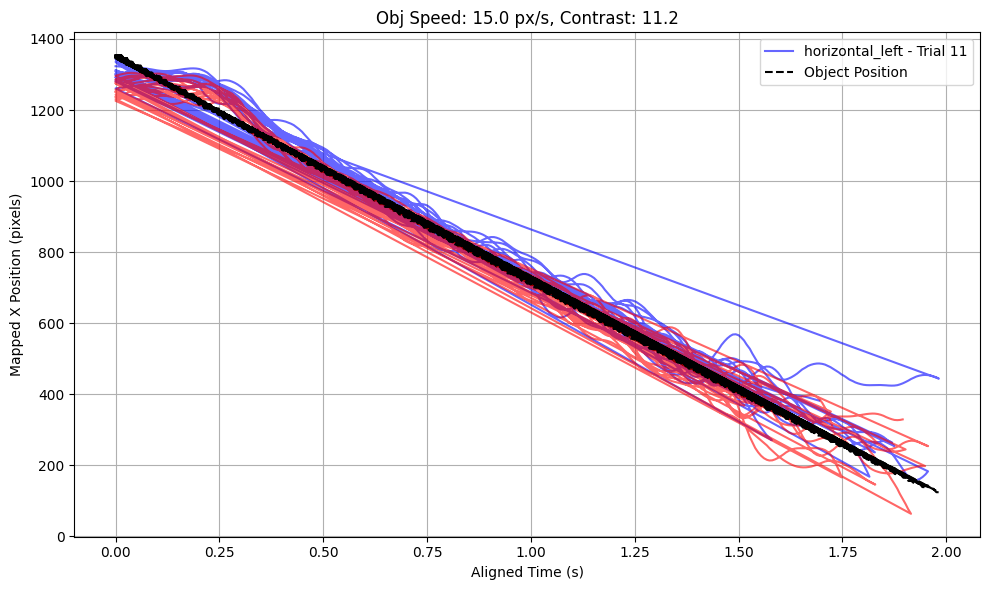

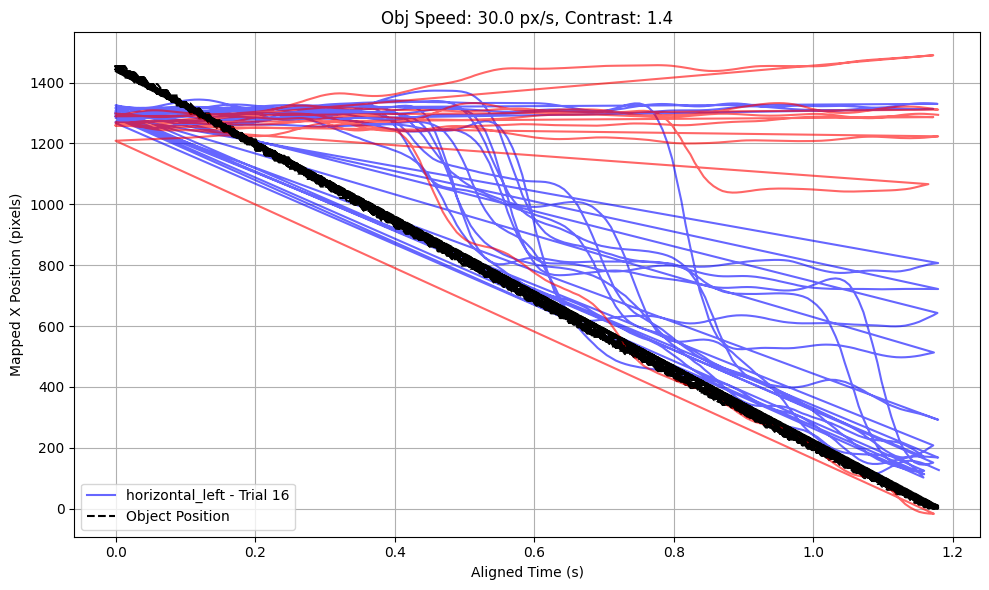

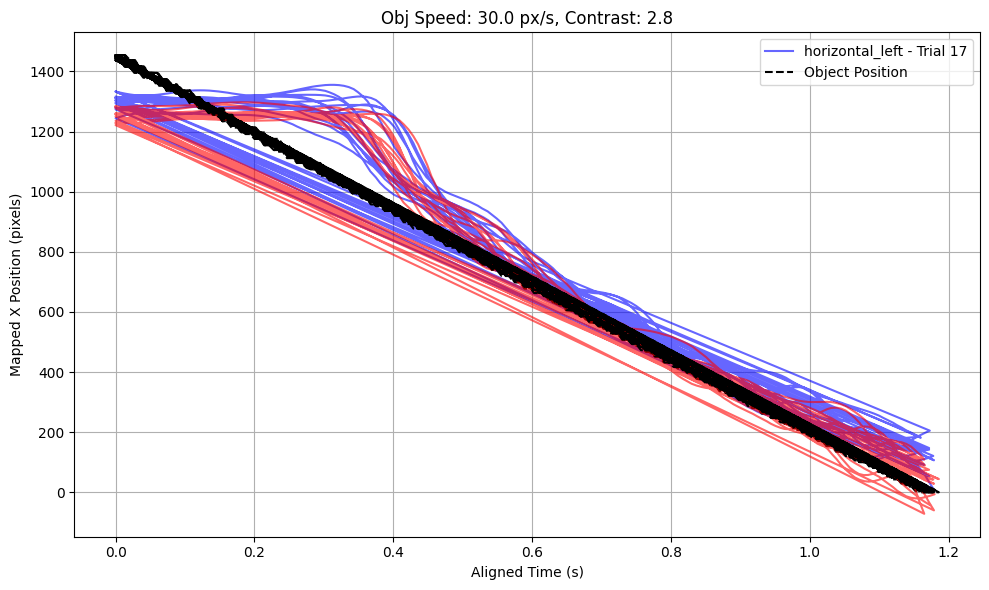

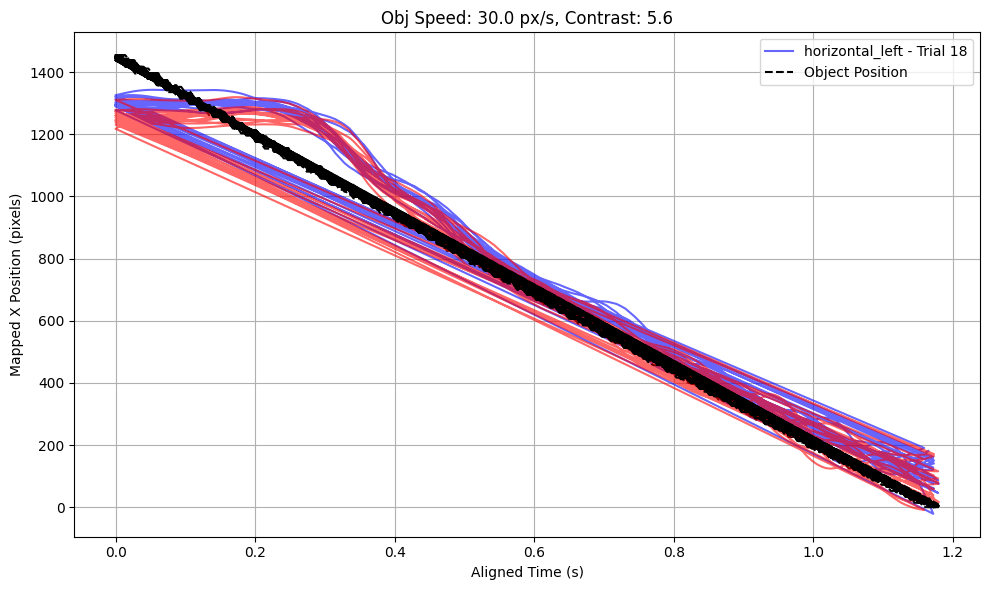

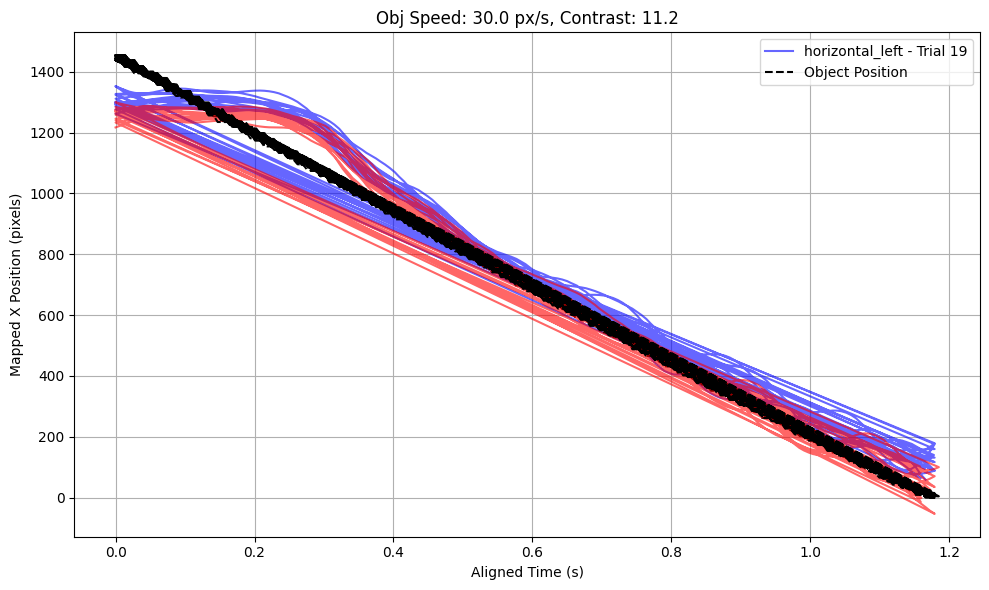

In [15]:
def plot_separate_trials(data, trial_details_df, contrast_threshold_column, alpha=0.6):
    import matplotlib.pyplot as plt

    # Define colors for directions
    direction_colors = {'horizontal_left': 'blue', 'horizontal_right': 'red'}

    # Iterate over unique object speeds and contrast thresholds
    for obj_speed in trial_details_df['object_speed'].unique():
        for contrast_threshold in trial_details_df[contrast_threshold_column].unique():
            # Filter trials based on object speed and contrast threshold
            filtered_trials = trial_details_df[
                (trial_details_df['object_speed'] == obj_speed) &
                (trial_details_df[contrast_threshold_column] == contrast_threshold)
            ]

            if filtered_trials.empty:
                continue

            # Get trial IDs matching the current filters
            unique_trial_ids = filtered_trials['trial_id'].unique()

            # Create a new plot for this combination
            plt.figure(figsize=(10, 6))

            for trial_id in unique_trial_ids:
                # Filter data for the current trial ID
                trial_data = data[data['TrialID'] == trial_id]

                if trial_data.empty:
                    continue

                # Plot data for each direction
                for direction, motion_x in [('horizontal_left', -1), ('horizontal_right', 1)]:
                    # Filter data for the current direction
                    direction_data = trial_data[trial_data['object_motion_x'] == motion_x]

                    if direction_data.empty:
                        continue

                    # Flip the rightward data for overlap
                    if direction == 'horizontal_right':
                        direction_data = direction_data.copy()
                        direction_data['FilteredPogX'] = -direction_data['FilteredPogX'] + screen_width
                        direction_data['BallX'] = -direction_data['BallX'] + screen_width

                    # Plot filtered gaze X positions
                    plt.plot(
                        direction_data['RelativeTime'],
                        direction_data['FilteredPogX'],
                        color=direction_colors[direction],
                        alpha=alpha,
                        label=f"{direction} - Trial {trial_id}" if trial_id == unique_trial_ids[0] else None  # Avoid duplicate labels
                    )

                    # Plot object position as a dashed black line
                    plt.plot(
                        direction_data['RelativeTime'],
                        direction_data['BallX'],
                        color='black',
                        linestyle='--',
                        label="Object Position" if trial_id == unique_trial_ids[0] and direction == 'horizontal_left' else None
                    )

            # Set plot titles and labels
            plt.title(f"Obj Speed: {obj_speed} px/s, Contrast: {contrast_threshold}")
            plt.xlabel("Aligned Time (s)")
            plt.ylabel("Mapped X Position (pixels)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()

            # Display the plot
            plt.show()

# Example usage
contrast_threshold_column = 'contrast_intensity'

plot_separate_trials(data, segment_df, contrast_threshold_column, alpha=0.6)


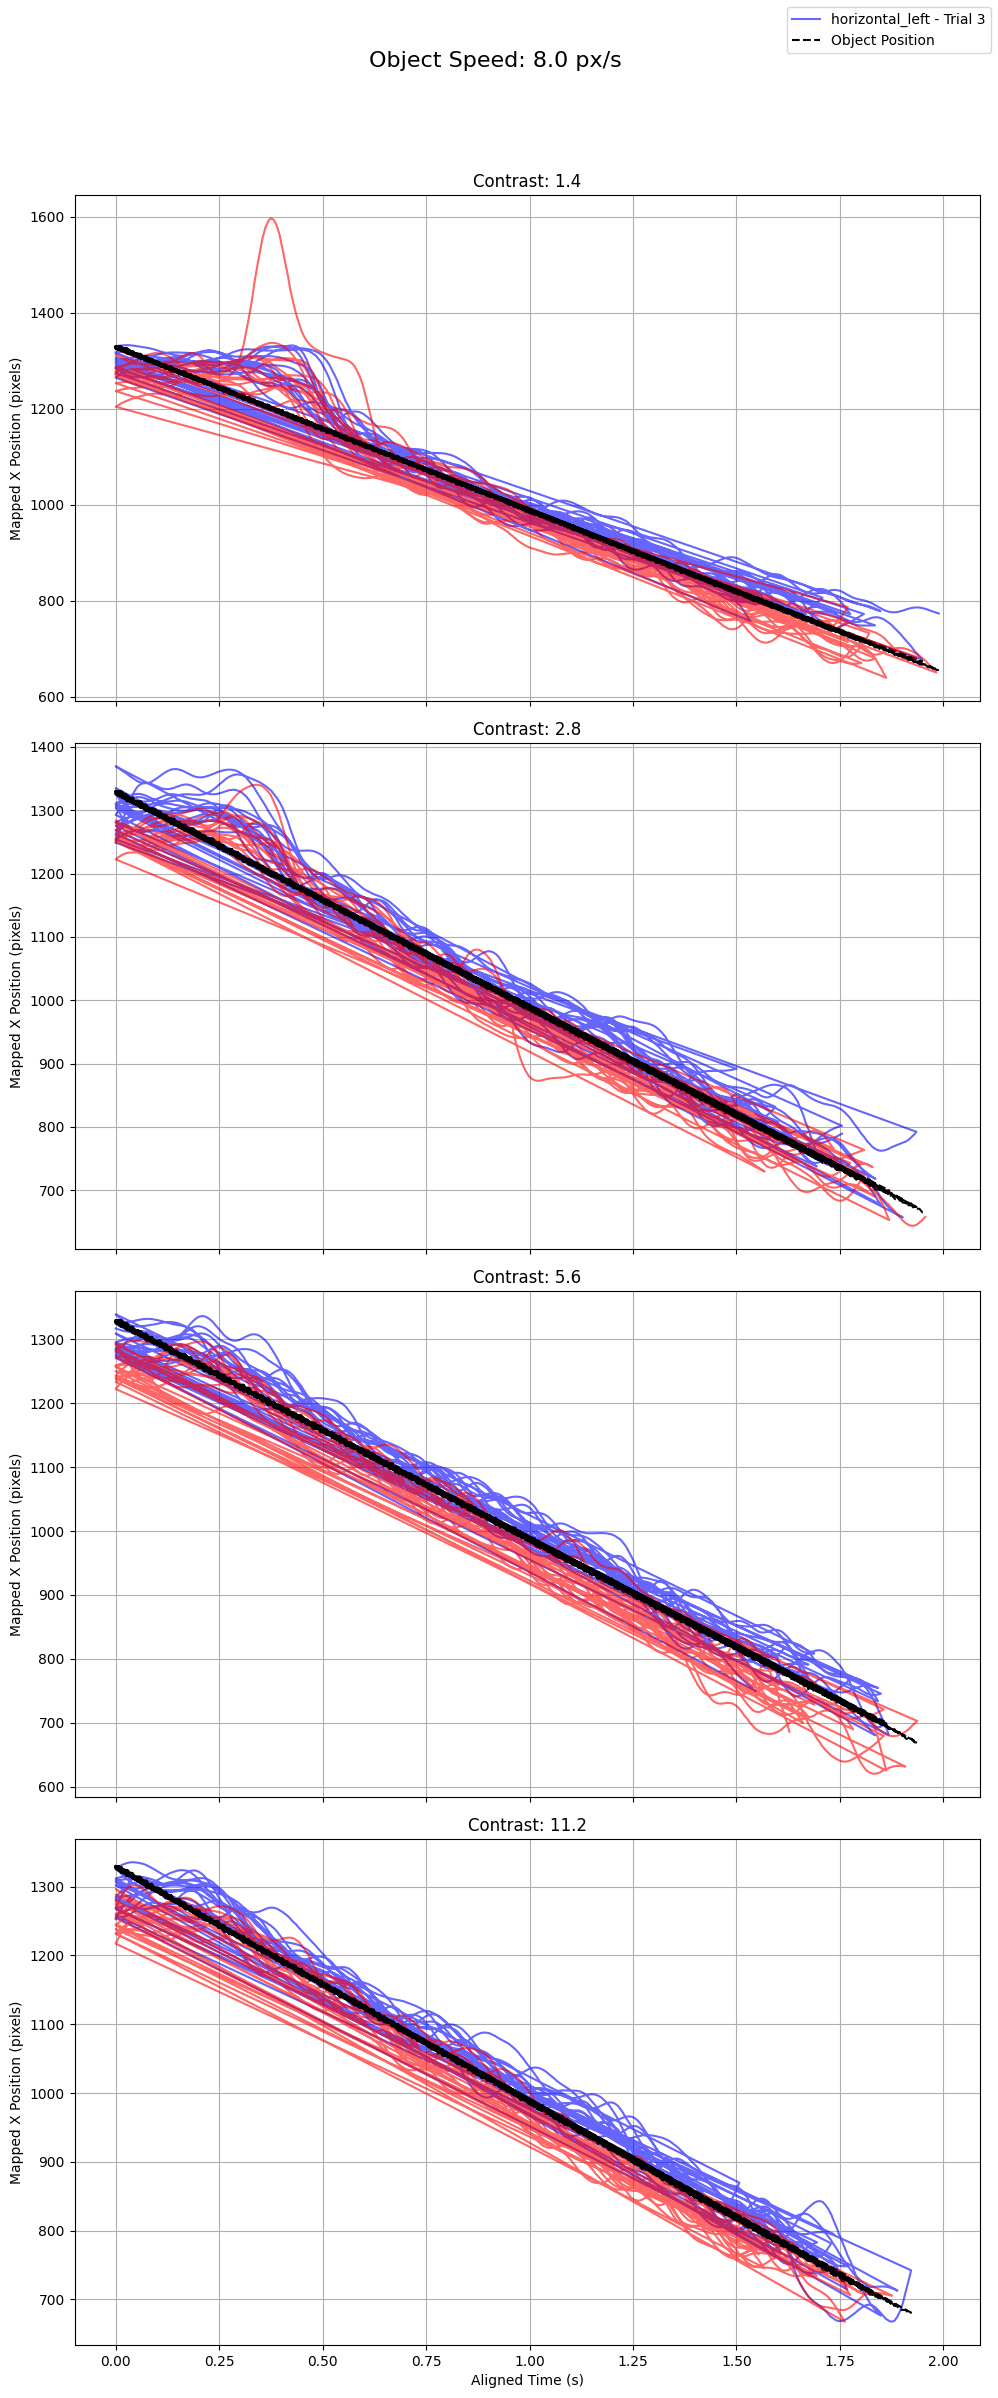

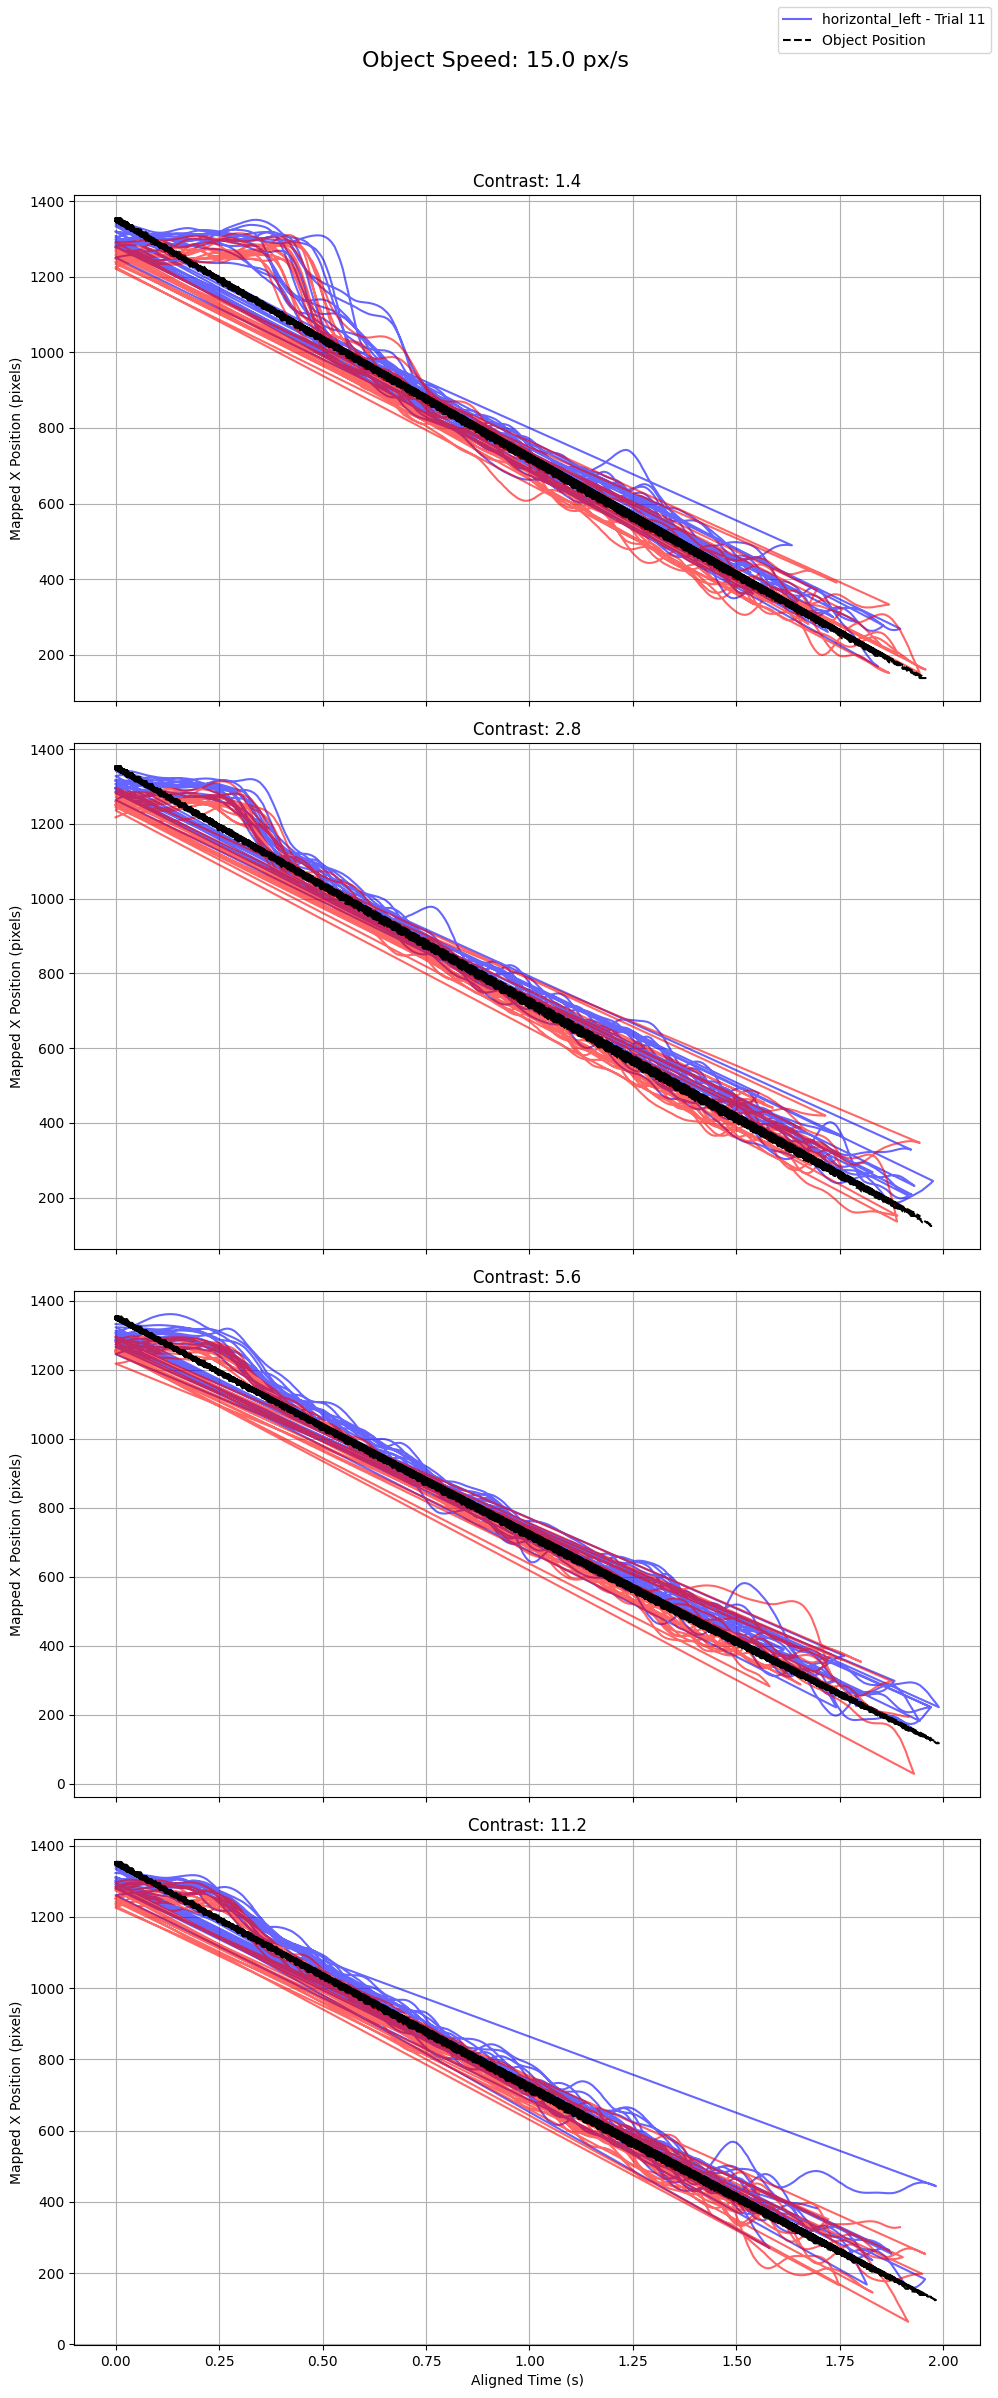

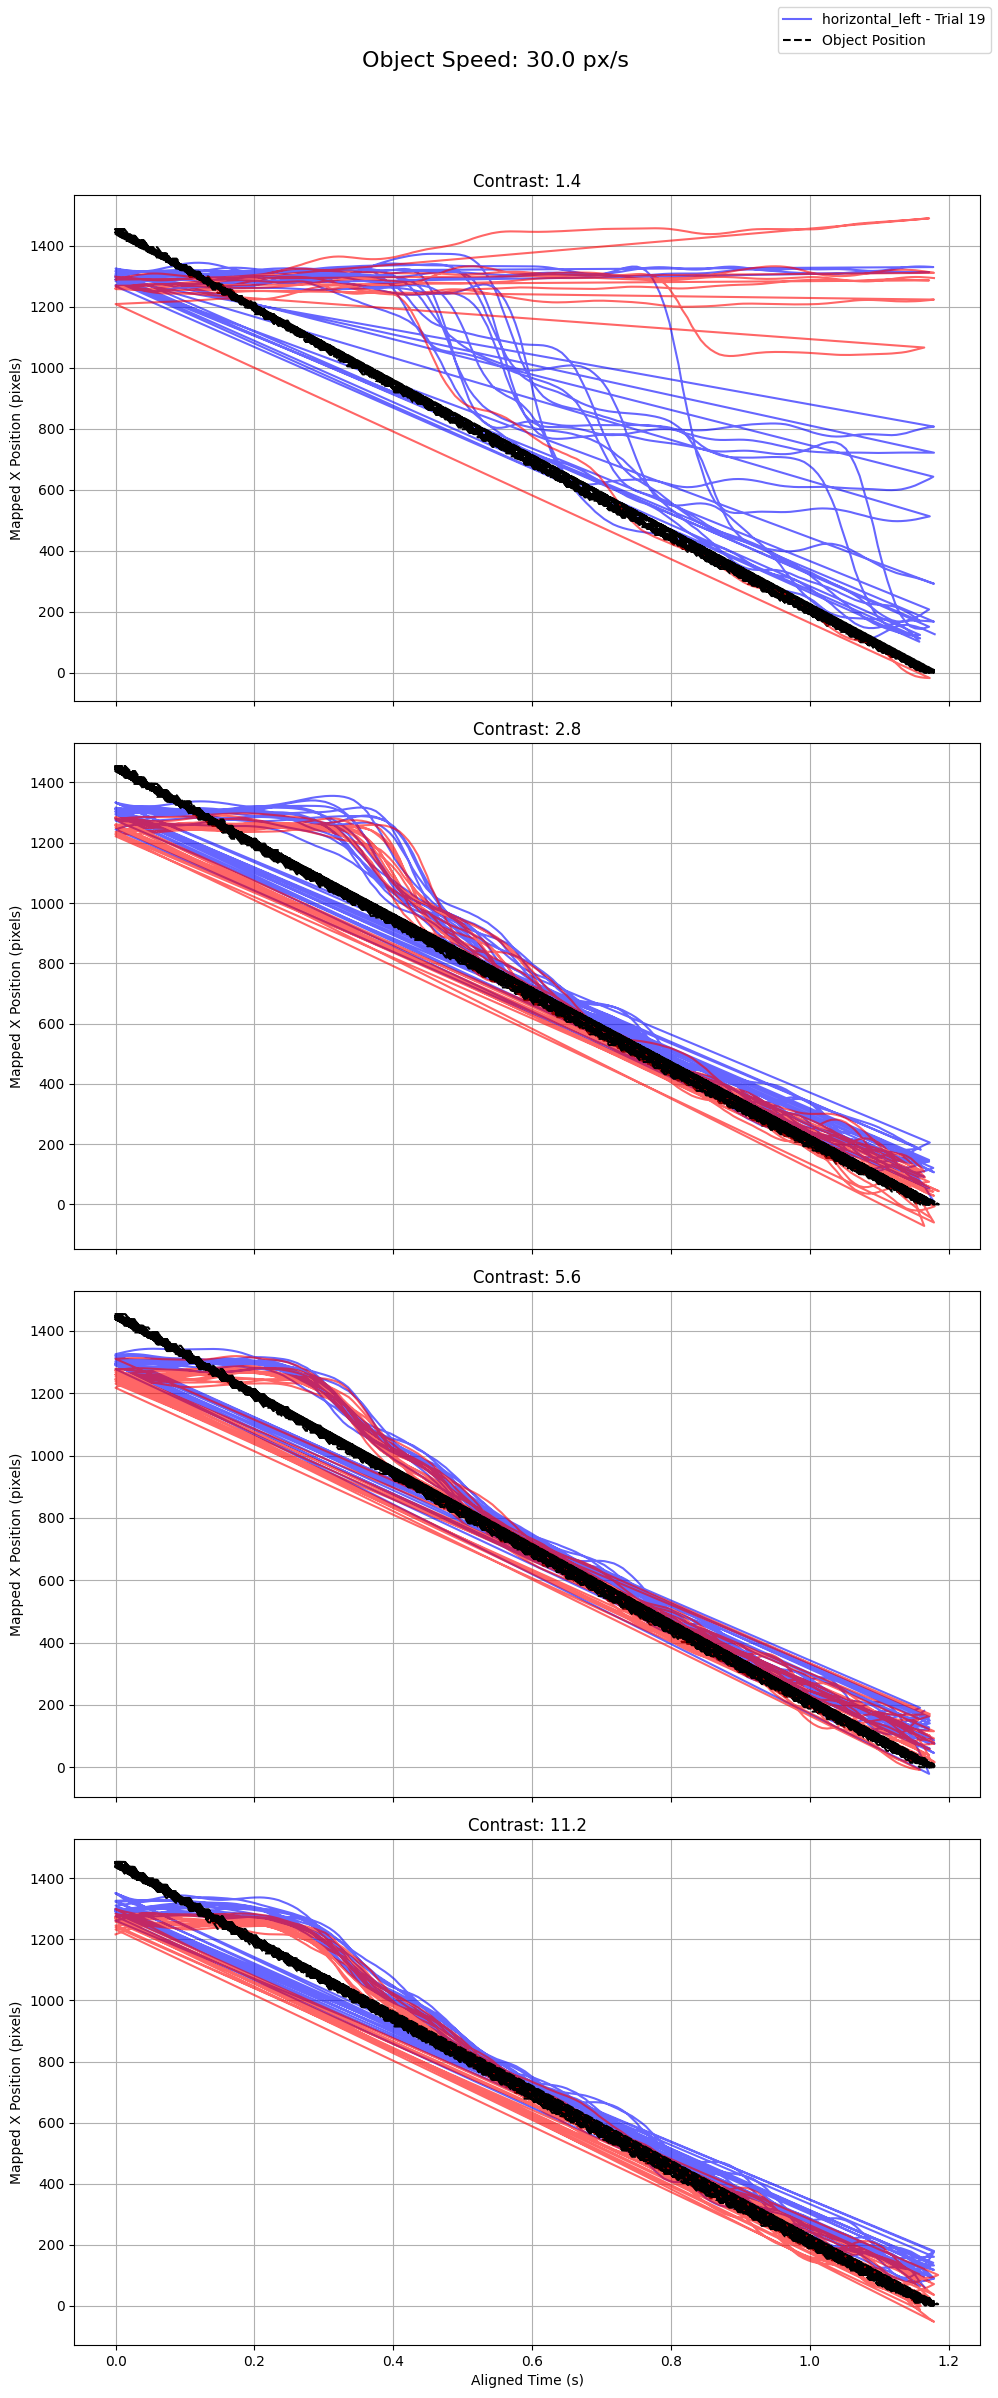

In [16]:
def plot_separate_trials_by_obj_speed(data, trial_details_df, contrast_threshold_column, alpha=0.6):
    import matplotlib.pyplot as plt
    import numpy as np

    # Define colors for directions
    direction_colors = {'horizontal_left': 'blue', 'horizontal_right': 'red'}

    # Iterate over unique object speeds
    for obj_speed in trial_details_df['object_speed'].unique():
        # Filter trials for the current object speed
        filtered_trials = trial_details_df[trial_details_df['object_speed'] == obj_speed]

        if filtered_trials.empty:
            continue

        # Get unique contrast thresholds for this object speed
        unique_contrast_thresholds = filtered_trials[contrast_threshold_column].unique()

        # Create subplots for each contrast threshold
        num_contrasts = len(unique_contrast_thresholds)
        fig, axes = plt.subplots(num_contrasts, 1, figsize=(10, 6 * num_contrasts), sharex=True)
        axes = np.atleast_1d(axes)  # Ensure axes is an array for single subplot case

        for ax, contrast_threshold in zip(axes, unique_contrast_thresholds):
            # Filter trials by contrast threshold
            contrast_trials = filtered_trials[filtered_trials[contrast_threshold_column] == contrast_threshold]
            unique_trial_ids = contrast_trials['trial_id'].unique()

            for trial_id in unique_trial_ids:
                # Filter data for the current trial ID
                trial_data = data[data['TrialID'] == trial_id]

                if trial_data.empty:
                    continue

                # Plot data for each direction
                for direction, motion_x in [('horizontal_left', -1), ('horizontal_right', 1)]:
                    # Filter data for the current direction
                    direction_data = trial_data[trial_data['object_motion_x'] == motion_x]

                    if direction_data.empty:
                        continue

                    # Flip the rightward data for overlap
                    if direction == 'horizontal_right':
                        direction_data = direction_data.copy()
                        direction_data['FilteredPogX'] = -direction_data['FilteredPogX'] + screen_width
                        direction_data['BallX'] = -direction_data['BallX'] + screen_width

                    # Plot filtered gaze X positions
                    ax.plot(
                        direction_data['RelativeTime'],
                        direction_data['FilteredPogX'],
                        color=direction_colors[direction],
                        alpha=alpha,
                        label=f"{direction} - Trial {trial_id}" if trial_id == unique_trial_ids[0] else None
                    )

                    # Plot object position as a dashed black line
                    ax.plot(
                        direction_data['RelativeTime'],
                        direction_data['BallX'],
                        color='black',
                        linestyle='--',
                        label="Object Position" if trial_id == unique_trial_ids[0] and direction == 'horizontal_left' else None
                    )

            # Set titles and labels for each subplot
            ax.set_title(f"Contrast: {contrast_threshold}")
            ax.set_ylabel("Mapped X Position (pixels)")
            ax.grid(True)
            if ax == axes[-1]:
                ax.set_xlabel("Aligned Time (s)")

        # Add a shared legend
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')

        # Set a title for the entire figure
        fig.suptitle(f"Object Speed: {obj_speed} px/s", fontsize=16)

        # Adjust layout and display
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Example usage
contrast_threshold_column = 'contrast_intensity'

plot_separate_trials_by_obj_speed(data, segment_df, contrast_threshold_column, alpha=0.6)
